In [35]:
!pip uninstall scikit-survival --yes

Found existing installation: scikit-survival 0.1.dev1191+gb489744.d20241126
Uninstalling scikit-survival-0.1.dev1191+gb489744.d20241126:
  Successfully uninstalled scikit-survival-0.1.dev1191+gb489744.d20241126


In [36]:
!pip install ../ --upgrade --no-cache-dir

Processing /workspaces/scikit-survival
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-survival: filename=scikit_survival-0.1.dev1191+gb489744.d20241126-cp312-cp312-linux_x86_64.whl size=3922657 sha256=d1c07547661dc82934eea5be7415d89ac4df70ac92d096a7be8bb973d042cf20
  Stored in directory: /tmp/pip-ephem-wheel-cache-4izccn_z/wheels/73/1e/1f/f68ce9295a139a820627ce9f5f205a9cafb3b63a64feff14ec
Successfully built scikit-survival


In [37]:
import pandas as pd

def _encode_categorical_columns(df, categorical_columns=None):
    """
    Automatically identifies categorical columns and applies one-hot encoding.

    Parameters:
    - df (pd.DataFrame): The input DataFrame with mixed continuous and categorical variables.
    - categorical_columns (list): Optional list of column names to treat as categorical.

    Returns:
    - pd.DataFrame: A new DataFrame with one-hot encoded categorical columns.
    """
    # Automatically identify categorical columns if not provided
    if categorical_columns is None:
        categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Apply one-hot encoding to the identified categorical columns
    df_encoded = pd.get_dummies(df, columns=categorical_columns)

    # Convert boolean columns to integer (0 and 1)
    bool_columns = df_encoded.select_dtypes(include=['bool']).columns.tolist()
    df_encoded[bool_columns] = df_encoded[bool_columns].astype(int)

    return df_encoded


In [38]:
import matplotlib.pyplot as plt
import numpy as np
from sksurv.datasets import load_whas500, load_gbsg2, load_veterans_lung_cancer
from sksurv.custom import PISurvivalCustom
from sksurv.tree import SurvivalTree
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, MultiTaskElasticNet, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import brier_score, integrated_brier_score
from time import time
import pandas as pd

def _encode_categorical_columns(df, categorical_columns=None):
    """
    Automatically identifies categorical columns and applies one-hot encoding.

    Parameters:
    - df (pd.DataFrame): The input DataFrame with mixed continuous and categorical variables.
    - categorical_columns (list): Optional list of column names to treat as categorical.

    Returns:
    - pd.DataFrame: A new DataFrame with one-hot encoded categorical columns.
    """
    # Automatically identify categorical columns if not provided
    if categorical_columns is None:
        categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Apply one-hot encoding to the identified categorical columns
    df_encoded = pd.get_dummies(df, columns=categorical_columns)

    # Convert boolean columns to integer (0 and 1)
    bool_columns = df_encoded.select_dtypes(include=['bool']).columns.tolist()
    df_encoded[bool_columns] = df_encoded[bool_columns].astype(int)

    return df_encoded


X, y = load_gbsg2()
X = _encode_categorical_columns(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sksurv.nonparametric import kaplan_meier_estimator

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PISurvivalCustom(regr=RandomForestRegressor())
estimator2 = GradientBoostingSurvivalAnalysis()

start = time()
estimator.fit(X_train, y_train)
print("Time to fit PIRandomForestRegressor: ", time() - start)
start = time()
estimator2.fit(X_train, y_train)
print("Time to fit SurvivalTree: ", time() - start)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])
surv_funcs2 = estimator2.predict_survival_function(X_test.iloc[:1])

print("km", km)
print("surv_funcs2", surv_funcs2)
print("surv_funcs.mean", surv_funcs.mean)
print("surv_funcs.lower", surv_funcs.lower)
print("surv_funcs.upper", surv_funcs.upper)

print(estimator.score(X_test, y_test))

Quantiles: 0.7585105478901996
Time to fit PIRandomForestRegressor:  11.84305715560913
Time to fit SurvivalTree:  0.35030460357666016
km (array([ 168.,  177.,  186.,  191.,  227.,  241.,  272.,  288.,  310.,
        322.,  338.,  344.,  348.,  350.,  369.,  374.,  375.,  377.,
        379.,  392.,  410.,  420.,  438.,  486.,  491.,  500.,  525.,
        526.,  529.,  544.,  548.,  564.,  575.,  577.,  594.,  615.,
        629.,  657.,  679.,  695.,  712.,  714.,  721.,  722.,  731.,
        748.,  753.,  772.,  779.,  784.,  801.,  825.,  827.,  828.,
        841.,  866.,  867.,  888.,  892.,  956.,  970.,  982., 1002.,
       1036., 1043., 1077., 1080., 1089., 1090., 1091., 1093., 1094.,
       1095., 1105., 1109., 1152., 1169., 1195., 1205., 1208., 1212.,
       1225., 1240., 1280., 1283., 1343., 1351., 1401., 1432., 1434.,
       1435., 1441., 1459., 1463., 1469., 1472., 1490., 1525., 1589.,
       1598., 1604., 1617., 1642., 1655., 1707., 1717., 1722., 1729.,
       1760., 1765., 17

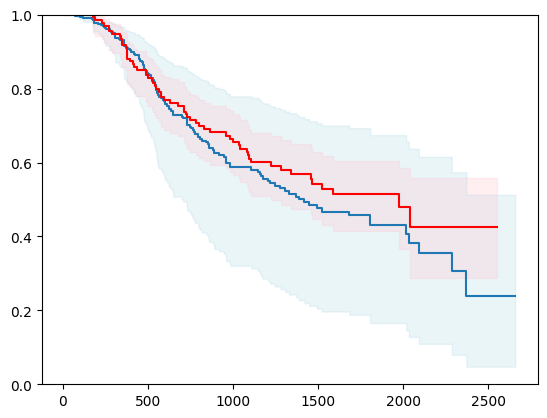

In [39]:
for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()




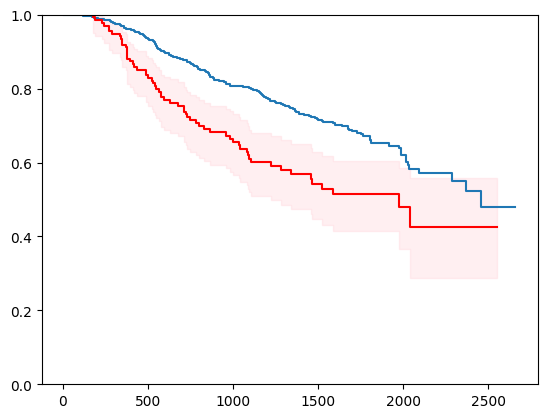

In [40]:
for fn in surv_funcs2:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()


Quantiles: 0.7776709399720911
Time to fit PIRandomForestRegressor:  7.116571426391602
0.6659912191827085


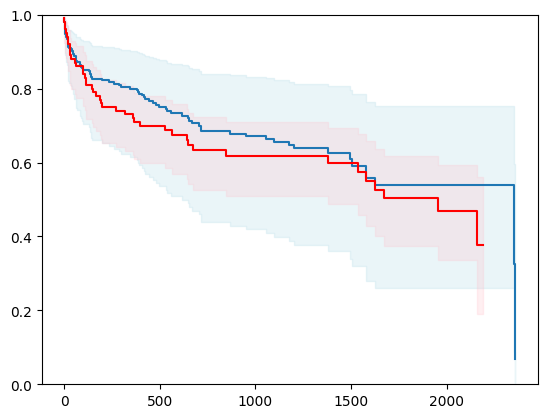

In [41]:
X, y = load_whas500()
X = _encode_categorical_columns(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PISurvivalCustom(regr=RandomForestRegressor())
estimator2 = GradientBoostingSurvivalAnalysis()

start = time()
estimator.fit(X_train, y_train)
print("Time to fit PIRandomForestRegressor: ", time() - start)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])

print(estimator.score(X_test, y_test))

for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()

Quantiles: 1.3927705927511056
Time to fit PIRandomForestRegressor:  1.9869968891143799
0.6868131868131868


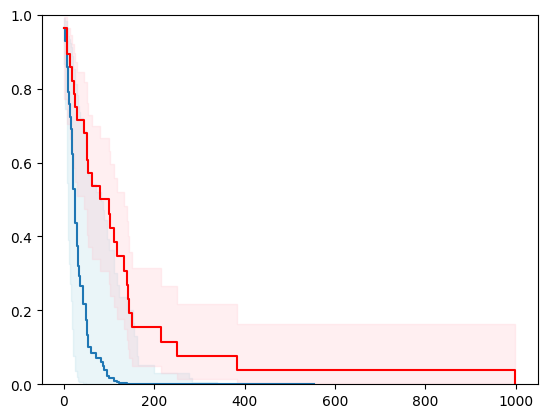

In [42]:
X, y = load_veterans_lung_cancer()
X = _encode_categorical_columns(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

event_time = [y[1] for y in y_test]
event_status = [y[0] for y in y_test]
km = kaplan_meier_estimator(event_status, event_time,
                            conf_type="log-log")
estimator = PISurvivalCustom(regr=RandomForestRegressor())
estimator2 = GradientBoostingSurvivalAnalysis()

start = time()
estimator.fit(X_train, y_train)
print("Time to fit PIRandomForestRegressor: ", time() - start)

surv_funcs = estimator.predict_survival_function(X_test.iloc[:1])

print(estimator.score(X_test, y_test))

for fn in surv_funcs.mean:
    plt.step(fn.x, fn(fn.x), where="post")
    plt.fill_between(fn.x, surv_funcs.lower[0].y, surv_funcs.upper[0].y, alpha=0.25, color="lightblue", step="post")
    plt.step(km[0], km[1], where="post", color="red", label="Kaplan-Meier")
    plt.fill_between(km[0], km[2][0], km[2][1], alpha=0.25, color="pink", step="post")
    plt.ylim(0, 1)
    plt.show()